# Simulated annealing for TSP

Warning: adjust the file path according to your OS

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [17]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([int(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

In [18]:
#Open initial file, store cities with coordinates
filename = "TSP-Configurations/eil51.tsp.txt"
init_cities = get_city_coord_dict(filename)

In [19]:
def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

In [32]:
def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()


# Initial city arrangement

Route distance of initial solutionis : 1313.4683444443463


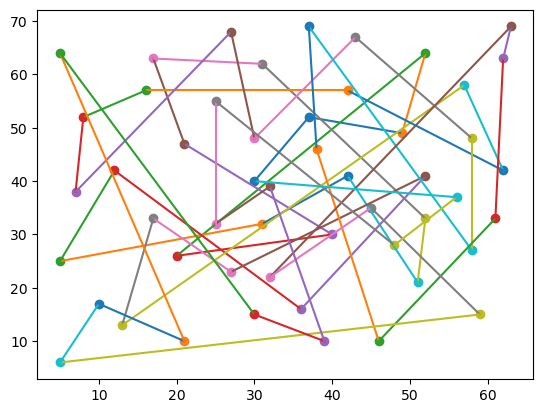

In [34]:
#Get distance of the initial arrangement of cities
init_distance = total_distance(init_cities)
print(f'Route distance of initial solutionis : {init_distance}')
#Visualize initial route arrangement
visualize_routes(init_cities)

In [22]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step = 100, init_seed = 1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.step = 0
        self.max_step = max_step
        self.seed = init_seed

    def proposal(self):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(self.cities_old.keys()))
        value = self.cities_old[random_key]

        proposal_cities = self.cities_old.copy()
        del proposal_cities[random_key]

        #Move it to here     
        new_index = np.random.randint(0, len(self.cities_old) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(self.cities_old.items())[:new_index] + [(random_key, value)] + list(self.cities_old.items())[new_index:])
        return proposal_cities

    
    def evaluate(self, cities, proposal_cities, T):
        alpha_func =  min(np.exp(-(total_distance(proposal_cities) - total_distance(cities))/T), 1)
        return alpha_func
    

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            #accept
            cities_new = proposal_cities
        else:
            #reject
            cities_new = self.cities_old

        return cities_new
    

    def run(self):
        while self.step < self.max_step:
            self.seed += 1
            # The temperature scheme (the cooling scheme)
            T = (self.C*np.log(self.step+self.T0))**(-1)
            self.step = self.step + 1
            # 1. Proposal
            proposal_cities = self.proposal()
            # 2. Evaluate
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            # 3. Select
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new

# Attempted solution

In [23]:
#Run the simulator
if __name__== '__main__':
    sim_annealing = SimulatedAnnealing(cities = init_cities, C = 0.1, T0 = 0.1, max_step = 200000)
    cities_new = sim_annealing.run()

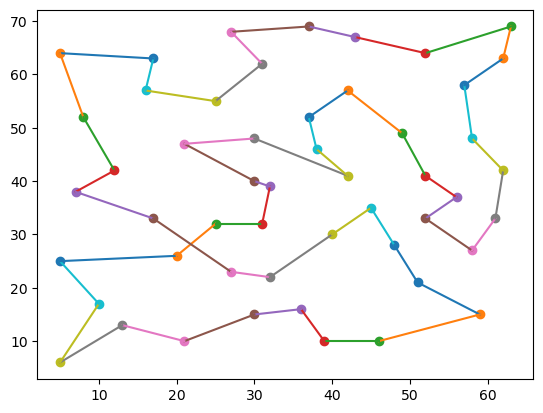

Total distance of simulated annealing solution is: 447.2143651087341
Order of the cities is as follows: odict_keys([10, 39, 33, 45, 15, 44, 42, 19, 40, 41, 13, 4, 47, 12, 46, 51, 6, 27, 11, 32, 1, 22, 2, 16, 50, 9, 30, 34, 21, 29, 20, 35, 36, 3, 28, 31, 26, 8, 48, 23, 7, 43, 24, 14, 25, 18, 17, 37, 5, 38, 49])


In [28]:
visualize_routes(cities_new)
print(f'Total distance of simulated annealing solution is: {total_distance(cities_new)}')
print(f'Order of the cities is as follows: {cities_new.keys()}')

# Compare with optimal solution

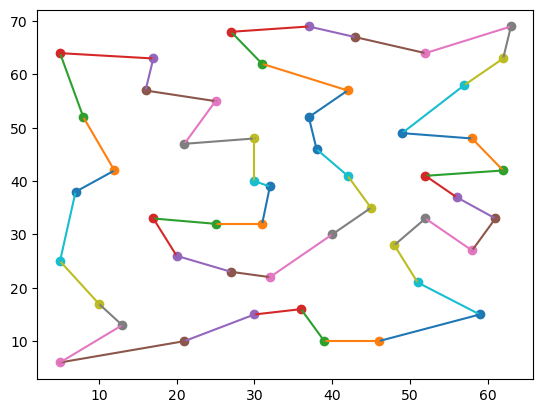

Total distance of optimal route is: 429.983311983384
Optimal order of the cities is as follows: odict_keys([1, 22, 8, 26, 31, 28, 3, 36, 35, 20, 2, 29, 21, 16, 50, 34, 30, 9, 49, 10, 39, 33, 45, 15, 44, 42, 40, 19, 41, 13, 25, 14, 24, 43, 7, 23, 48, 6, 27, 51, 46, 12, 47, 18, 4, 17, 37, 5, 38, 11, 32])


In [31]:
def get_optimal_sol(filename, cities_dict):
    '''Opens the file with cities ordered for an optimal path. Sorted input dictionary accordingly.
    Input: file name with path, city/coordinate dictionary to be sorted
    Ouput: Optimally sorted ordered dictionary of cities with corresponding x and y coordinates (numpy array)'''
    city_order = []

    with open(filename, 'r') as file:
        tour_section_started = False

        for line in file:
            line = line.strip()

            if tour_section_started and line[0].isdigit():
                city_order.append(int(line))
            elif line.startswith("TOUR_SECTION"):
                tour_section_started = True
            elif line.startswith("-1"):
                break
        
    opt_sol_dict = OrderedDict((key, cities_dict[key]) for key in city_order)
        
    return opt_sol_dict


#Compare with optimal solution
filename = "TSP-Configurations/eil51.opt.tour.txt"
opt_sol_dict = get_optimal_sol(filename, init_cities)
visualize_routes(opt_sol_dict)
print(f'Total distance of optimal route is: {total_distance(opt_sol_dict)}')
print(f'Optimal order of the cities is as follows: {opt_sol_dict.keys()}')